# Gradient Boosted Regression Tree (GBRT)
### Using XGBoost Regressor

In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform as sp_randFloat, randint as sp_randInt

from yellowbrick.regressor import ResidualsPlot, PredictionError

# Set plot style
plt.style.use('ggplot')

In [230]:
data = pd.read_csv("data/linked_data.csv")

### Define Random Search for Hyperparameter Tuning

In [231]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data,
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error'):

    gs = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid,
            cv=cv,
            n_jobs=-1,
            scoring=scoring_fit,
            verbose=2,
            n_iter=100,
    )

    fitted_model = gs.fit(X_train_data, y_train_data)
    pred = fitted_model.predict(X_test_data)

    return fitted_model, pred

In [232]:
# Parameters for random search
param_grid = {'max_depth': sp_randInt(3,20),
              'learning_rate': sp_randFloat(),
              'subsample': sp_randFloat(),
              'colsample_bytree': sp_randFloat(),
              'colsample_bylevel': sp_randFloat(),
              'n_estimators': sp_randInt(100,1000)}

### Univariable XGBoost Regressor

In [233]:
x = data.loc[:, 'log_weighted_avg']
x2 = data.loc[:, 'log_gc_per_day']
y = data.loc[:, 'avg_r_avg']

In [234]:
# Split 80% data for training and 20% for test, following Morvan et. al (function default 25% test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

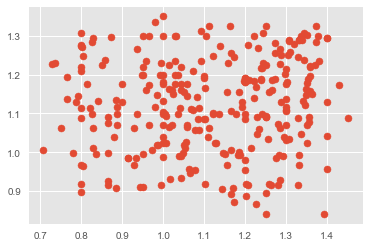

In [235]:
# Initial 'plain' model: univariable model without tuning
xgbr = XGBRegressor()
plain_fit = xgbr.fit(x_train, y_train)
plain_pred = plain_fit.predict(x_test)

# Scatter plot of actual and predicted values
plt.scatter(y_test, plain_pred)

In [236]:
# RMSE
plain_rmse = np.sqrt(mean_squared_error(y_test, plain_pred))

In [237]:
# Univariable model with tuning
uni_model, uni_pred = algorithm_pipeline(x_train, x_test, y_train, xgbr, param_grid, cv=10)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [238]:
# Best parameters
uni_model.best_params_

{'colsample_bylevel': 0.7693844837232874,
 'colsample_bytree': 0.1976707896389276,
 'learning_rate': 0.008501997272248651,
 'max_depth': 18,
 'n_estimators': 420,
 'subsample': 0.3894010557896719}

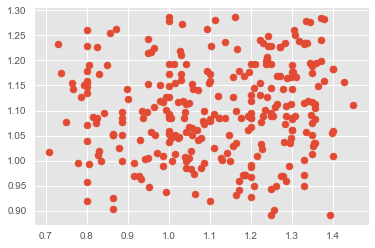

In [239]:
# Scatter plot of actual and predicted values
plt.scatter(y_test, uni_pred)

In [240]:
# RMSE
rmse = np.sqrt(mean_squared_error(y_test, uni_pred))

<AxesSubplot:title={'center':'Prediction Error for Univariable Model'}, xlabel='$y$', ylabel='$\\hat{y}$'>

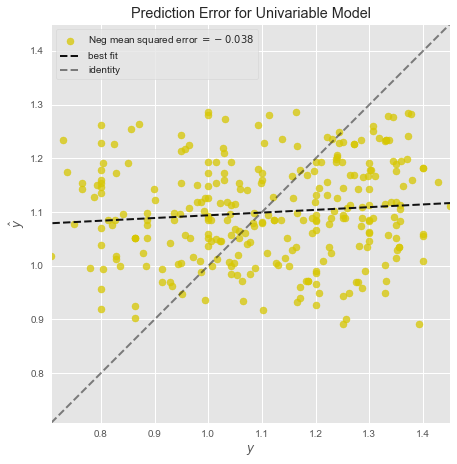

In [271]:
# Making the Prediction Error Plot
my_title = "Prediction Error for Univariable Model"
visualiser1 = PredictionError(uni_model,
                              size=(528, 528),
                              title=my_title,
                              point_color='y'
                              )
visualiser1.fit(x_train, y_train)
visualiser1.score(x_test, y_test)
visualiser1.show(outpath="plots/Prediction Error Plot (Uni).png")

<AxesSubplot:title={'center':'Residuals for Univariable Model (w/ Tuning)'}, xlabel='Predicted Value', ylabel='Residuals'>

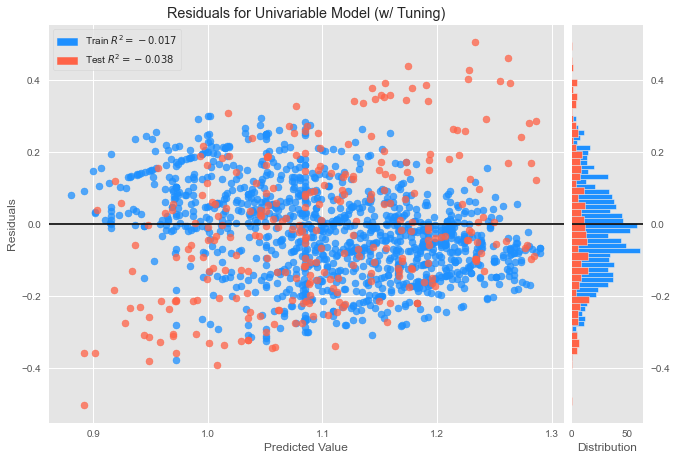

In [242]:
# Making the Residuals Plot
plt.figure()
uni_title = "Residuals for Univariable Model (w/ Tuning)"
visualiser2 = ResidualsPlot(uni_model,
                            train_color="dodgerblue",
                            test_color="tomato",
                            size=(768, 528),
                            title=uni_title
                            )

visualiser2.fit(x_train, y_train)
visualiser2.score(x_test, y_test)
visualiser2.show(outpath="plots/Residuals Plot (Uni).png")

### Multivariable regression model

In [243]:
from sklearn.preprocessing import OneHotEncoder

In [244]:
# Create one-hot encoder for categorical variable - region
enc = OneHotEncoder(handle_unknown='ignore')

# Transform column and convert to dataframe
encoder_df = pd.DataFrame(enc.fit_transform(data[['region']]).toarray())

#rename columns
encoder_df.columns =['East Midlands', 'East Of England', 'London' , 'North East', 'North West', 'South East', 'South West', 'West Midlands', 'Yorkshire And The Humber']

# Join with original data
multidata = data.join(encoder_df)

In [245]:
# Multivariable features
X = multidata[['log_weighted_avg', 'log_suspended_solids', 'log_ammonia', 'log_ophosph','sample_ph_weighted', 'raw_ansis_sars_repc_std_weighted', 'compo_frac_weighted', 'sars_below_lod_weighted', 'reception_delay_weighted', 'East Midlands', 'East Of England', 'London' , 'North East', 'North West', 'South East', 'South West', 'West Midlands', 'Yorkshire And The Humber']]

In [246]:
# Lower and upper bounds
Y = multidata.loc[:, 'avg_r_avg']
Ylow = multidata.loc[:, 'avg_r_lower']
Yup = multidata.loc[:, 'avg_r_upper']

In [247]:
# avg R
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# lower bound R
Xlow_train, Xlow_test, Ylow_train, Ylow_test = train_test_split(X, Ylow, test_size=0.2, random_state=42)

# upper bound R
Xup_train, Xup_test, Yup_train, Yup_test = train_test_split(X, Yup, test_size=0.2, random_state=42)

In [248]:
# Build model for avg R
multi_model, multi_pred = algorithm_pipeline(X_train, X_test, Y_train, xgbr, param_grid, cv=10)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [249]:
# Show best hyperparameters
multi_model.best_params_

{'colsample_bylevel': 0.045382435365559526,
 'colsample_bytree': 0.8611526903982737,
 'learning_rate': 0.04551011465150656,
 'max_depth': 14,
 'n_estimators': 647,
 'subsample': 0.5062334151225477}

<AxesSubplot:title={'center':'Prediction Error for Multivariable Model'}, xlabel='$y$', ylabel='$\\hat{y}$'>

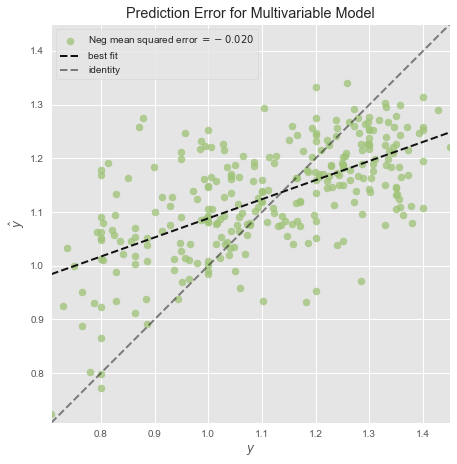

In [274]:
# Making the Prediction Error Plot
my_title = "Prediction Error for Multivariable Model"
visualiser1 = PredictionError(multi_model,
                              size=(528, 528),
                              title=my_title,
                              point_color='g'
                              )
visualiser1.fit(X_train, Y_train)
visualiser1.score(X_test, Y_test)
visualiser1.show(outpath="plots/Prediction Error Plot.png")

<AxesSubplot:title={'center':'Residuals for Multivariable Model (w/ Tuning)'}, xlabel='Predicted Value', ylabel='Residuals'>

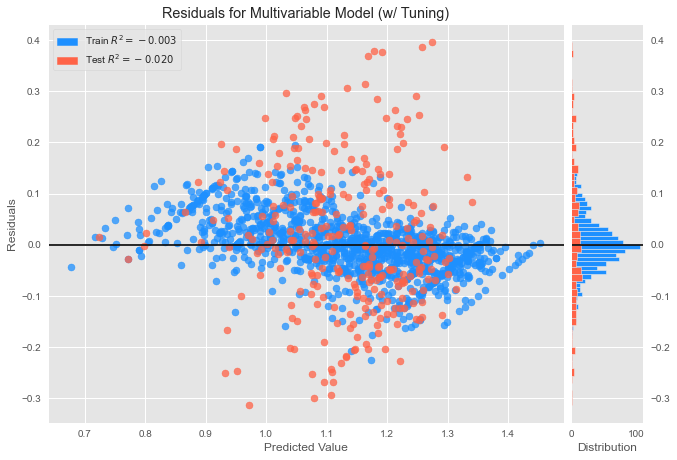

In [251]:
# Making the Residuals Plot
plt.figure()
multi_title = "Residuals for Multivariable Model (w/ Tuning)"
visualiser2 = ResidualsPlot(multi_model,
                             train_color="dodgerblue",
                             test_color="tomato",
                             size=(768, 528),
                             title=multi_title
                             )

visualiser2.fit(X_train, Y_train,)
visualiser2.score(X_test, Y_test)
visualiser2.show(outpath="plots/Residuals Plot.png")

In [252]:
multi_rmse = np.sqrt(mean_squared_error(Y_test, multi_pred))

In [253]:
multi_model_low, multi_pred_low = algorithm_pipeline(Xlow_train, Xlow_test, Ylow_train, xgbr, param_grid, cv=10)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END colsample_bylevel=0.8304683398701895, colsample_bytree=0.24478393196296788, learning_rate=0.30248473205202564, max_depth=15, n_estimators=946, subsample=0.1945248799018937; total time=   1.1s
[CV] END colsample_bylevel=0.6464936445166338, colsample_bytree=0.4390664636205215, learning_rate=0.30207764133408055, max_depth=17, n_estimators=332, subsample=0.5283694400739153; total time=   0.4s
[CV] END colsample_bylevel=0.6464936445166338, colsample_bytree=0.4390664636205215, learning_rate=0.30207764133408055, max_depth=17, n_estimators=332, subsample=0.5283694400739153; total time=   0.4s
[CV] END colsample_bylevel=0.6079040284469645, colsample_bytree=0.5147298304440888, learning_rate=0.8332091159926625, max_depth=7, n_estimators=443, subsample=0.7847513043771901; total time=   0.3s
[CV] END colsample_bylevel=0.8891013515593433, colsample_bytree=0.8569614511430642, learning_rate=0.29627609644072705, max_depth=9, n_es

In [254]:
multi_rmse_low = np.sqrt(mean_squared_error(Ylow_test, multi_pred_low))

In [255]:
multi_model_up, multi_pred_up = algorithm_pipeline(Xup_train, Xup_test, Yup_train, xgbr, param_grid, cv=10)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END colsample_bylevel=0.8304683398701895, colsample_bytree=0.24478393196296788, learning_rate=0.30248473205202564, max_depth=15, n_estimators=946, subsample=0.1945248799018937; total time=   1.1s
[CV] END colsample_bylevel=0.6464936445166338, colsample_bytree=0.4390664636205215, learning_rate=0.30207764133408055, max_depth=17, n_estimators=332, subsample=0.5283694400739153; total time=   0.5s
[CV] END colsample_bylevel=0.5673322122733473, colsample_bytree=0.841722796067052, learning_rate=0.24466954951846343, max_depth=6, n_estimators=153, subsample=0.6394852699923461; total time=   0.1s
[CV] END colsample_bylevel=0.5673322122733473, colsample_bytree=0.841722796067052, learning_rate=0.24466954951846343, max_depth=6, n_estimators=153, subsample=0.6394852699923461; total time=   0.1s
[CV] END colsample_bylevel=0.5673322122733473, colsample_bytree=0.841722796067052, learning_rate=0.24466954951846343, max_depth=6, n_estim

In [256]:
multi_rmse_up = np.sqrt(mean_squared_error(Yup_test, multi_pred_up))

### RMSE Plot

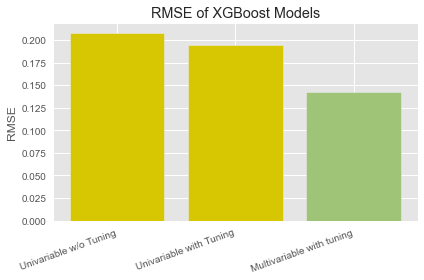

In [257]:
objects = ('Univariable w/o Tuning', 'Univariable with Tuning', 'Multivariable with tuning')
y_pos = np.arange(len(objects))
performance = [plain_rmse, rmse, multi_rmse]
cr = ['y', 'y', 'g']

gx = plt.bar(y_pos, performance, align='center', color=cr)
plt.xticks(y_pos, objects, rotation=20, ha='right')
plt.ylabel('RMSE')
plt.title('RMSE of XGBoost Models')
plt.tight_layout()

plt.savefig('plots/RMSE Plot.png', dpi=100)

In [258]:
print(plain_rmse, rmse)
print(multi_rmse, multi_rmse_low, multi_rmse_up)

0.2080103424881928 0.1948712679142012
0.1425972418503253 0.14469059011042237 0.15183165506359367


### Partial Dependence Plot

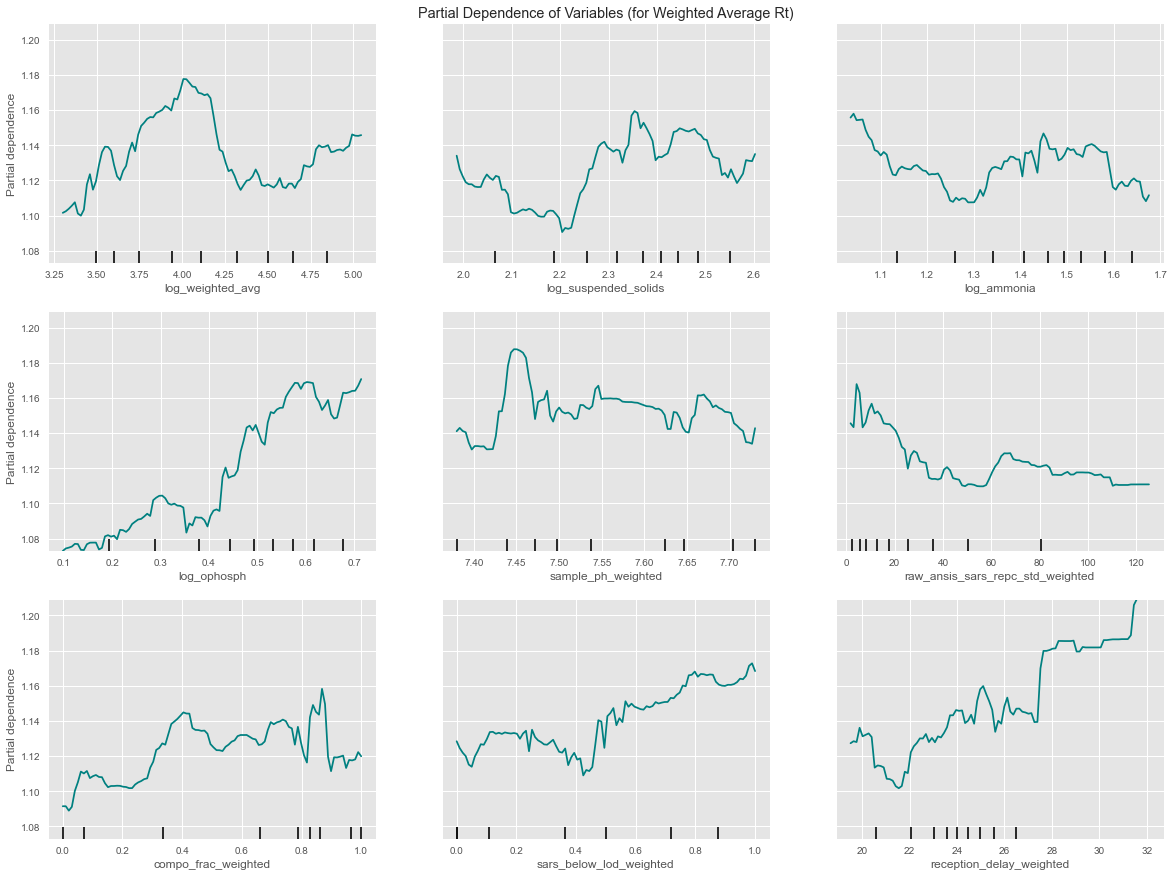

In [280]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(20, 15))
ax.set_title("Partial Dependence of Variables (for Weighted Average Rt)")
disp = PartialDependenceDisplay.from_estimator(multi_model, X, ['log_weighted_avg', 'log_suspended_solids', 'log_ammonia', 'log_ophosph', 'sample_ph_weighted', 'raw_ansis_sars_repc_std_weighted', 'compo_frac_weighted', 'sars_below_lod_weighted', 'reception_delay_weighted'],
                                               ax=ax, # subplot settings
                                               line_kw={"color": "teal"} # line colour
                                               )

plt.savefig('plots/PDP1.png')

In [266]:
# fig, bx = plt.subplots(figsize=(20, 15))
# bx.set_title("Partial Dependence of Variables (for Weighted Average Rt)")
# disp = PartialDependenceDisplay.from_estimator(multi_model, X, ['East Midlands', 'East Of England', 'London' , 'North East', 'North West', 'South East', 'South West', 'West Midlands', 'Yorkshire And The Humber'],
#                                                ax=bx, # subplot settings
#                                                line_kw={"color": "teal"} # line colour
#                                                )
#
# plt.savefig('plots/PDP2.png')